<a href="https://colab.research.google.com/github/zahraniayudyaa/TUGAS-ML/blob/main/ch_07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Pengantar Ensemble Learning**
---
Ensemble Learning adalah teknik yang menggabungkan prediksi dari beberapa model (disebut ensemble) untuk mendapatkan prediksi yang lebih baik daripada model individual. Analoginya adalah "wisdom of the crowd" - jawaban agregat dari ribuan orang acak seringkali lebih baik daripada jawaban seorang ahli. Dalam konteks machine learning, ensemble method menggabungkan beberapa predictor (classifier atau regressor) untuk meningkatkan akurasi prediksi.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import warnings
warnings.filterwarnings('ignore')

# Set style untuk visualisasi
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# **2. Voting Classifiers**
---
Voting classifier menggabungkan prediksi dari beberapa classifier berbeda dengan cara:
* **Hard voting:** memilih kelas yang mendapatkan suara terbanyak
* **Soft voting:** menghitung rata-rata probabilitas kelas dari semua classifier dan memilih kelas dengan probabilitas tertinggi

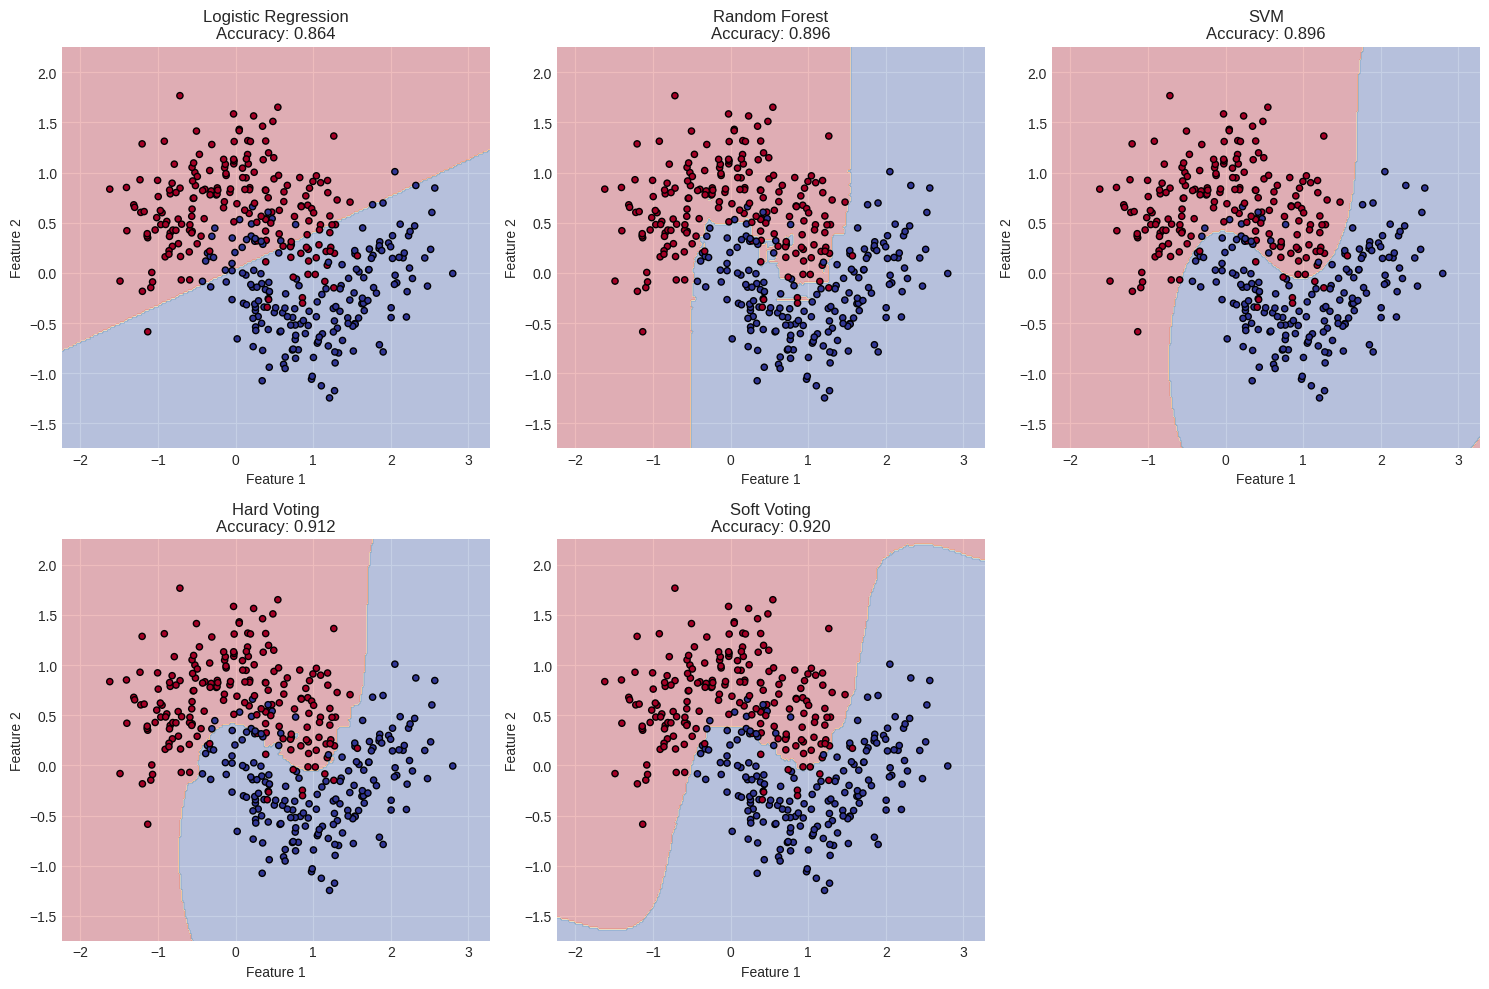

In [2]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_moons

# Generate moons dataset
X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Create individual classifiers
log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(probability=True, random_state=42)

# Create voting classifiers
voting_clf_hard = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard'
)

voting_clf_soft = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft'
)

# Train all classifiers
classifiers = {
    'Logistic Regression': log_clf,
    'Random Forest': rnd_clf,
    'SVM': svm_clf,
    'Hard Voting': voting_clf_hard,
    'Soft Voting': voting_clf_soft
}

# Visualisasi decision boundaries
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

# Buat meshgrid untuk plotting
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

for idx, (name, clf) in enumerate(classifiers.items()):
    clf.fit(X_train, y_train)

    # Plot decision boundary
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axes[idx].contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.RdYlBu)
    axes[idx].scatter(X_train[:, 0], X_train[:, 1], c=y_train,
                     cmap=plt.cm.RdYlBu, edgecolor='black', s=20)
    axes[idx].set_title(f'{name}\nAccuracy: {accuracy_score(y_test, clf.predict(X_test)):.3f}')
    axes[idx].set_xlabel('Feature 1')
    axes[idx].set_ylabel('Feature 2')

# Hapus axes terakhir yang tidak terpakai
axes[-1].axis('off')
plt.tight_layout()
plt.show()

Dari visualisasi di atas, kita dapat melihat bahwa:
* Setiap classifier memiliki decision boundary yang berbeda
* Voting classifiers (hard dan soft) menghasilkan decision boundary yang lebih smooth
* Soft voting umumnya memberikan hasil terbaik karena mempertimbangkan confidence setiap classifier

# **3. Bagging and Pasting**
---
Bagging (Bootstrap Aggregating) dan Pasting melatih beberapa predictor menggunakan algoritma yang sama pada subset data training yang berbeda. Perbedaan utama adalah:
* **Bagging:** sampling dengan replacement (bootstrap)
* **Pasting:** sampling tanpa replacement

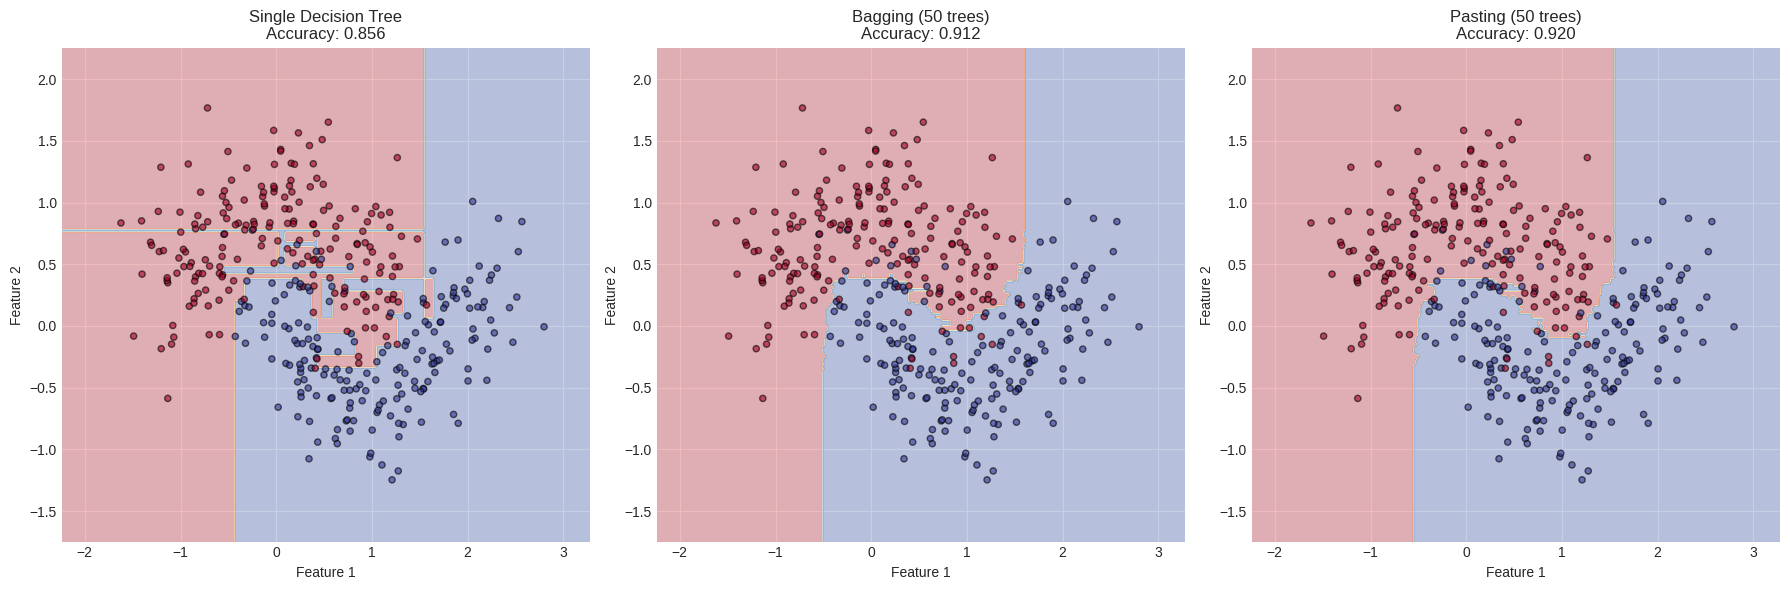

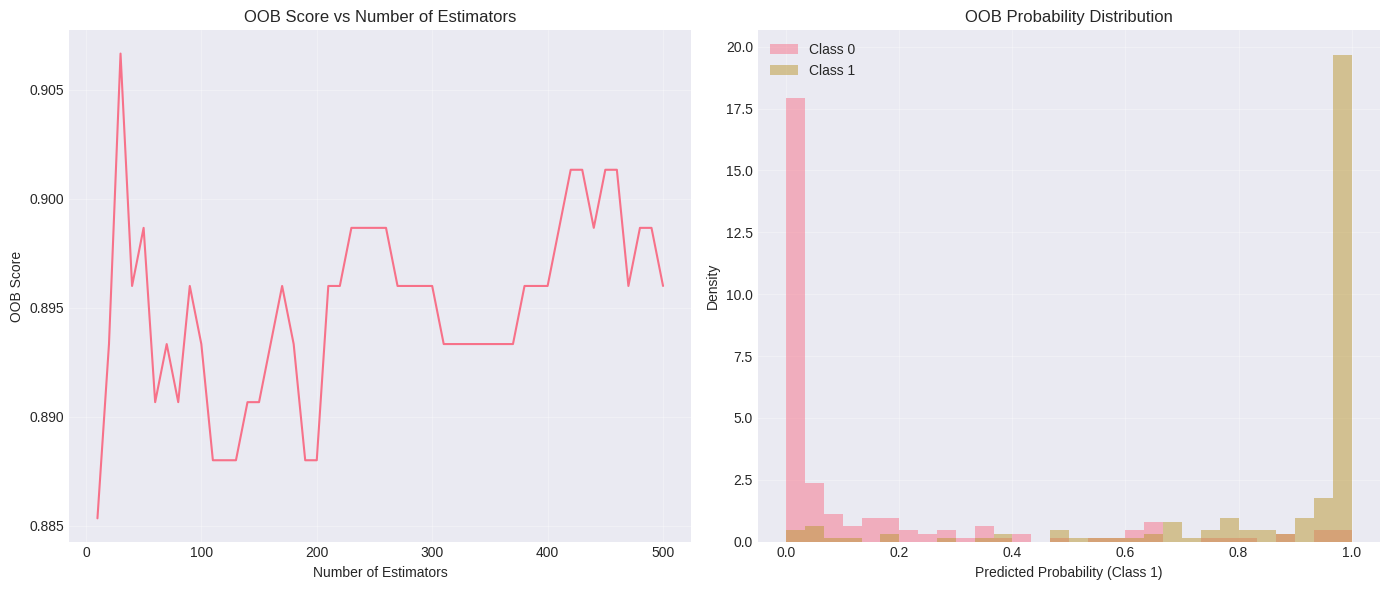

Final OOB Score: 0.896
Test Accuracy: 0.920


In [3]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# Visualisasi perbedaan Bagging dan Pasting
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Single Decision Tree
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)

# Bagging Classifier
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42),
    n_estimators=50,
    max_samples=100,
    bootstrap=True,
    n_jobs=-1,
    random_state=42
)
bag_clf.fit(X_train, y_train)

# Pasting Classifier
paste_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42),
    n_estimators=50,
    max_samples=100,
    bootstrap=False,
    n_jobs=-1,
    random_state=42
)
paste_clf.fit(X_train, y_train)

# Plot decision boundaries
classifiers_plot = [
    ('Single Decision Tree', tree_clf),
    ('Bagging (50 trees)', bag_clf),
    ('Pasting (50 trees)', paste_clf)
]

for idx, (name, clf) in enumerate(classifiers_plot):
    # Plot decision boundary
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axes[idx].contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.RdYlBu)
    axes[idx].scatter(X_train[:, 0], X_train[:, 1], c=y_train,
                     cmap=plt.cm.RdYlBu, edgecolor='black', s=20, alpha=0.6)
    axes[idx].set_title(f'{name}\nAccuracy: {accuracy_score(y_test, clf.predict(X_test)):.3f}')
    axes[idx].set_xlabel('Feature 1')
    axes[idx].set_ylabel('Feature 2')

plt.tight_layout()
plt.show()

# Visualisasi Out-of-Bag Evaluation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Bagging dengan OOB
bag_clf_oob = BaggingClassifier(
    DecisionTreeClassifier(random_state=42),
    n_estimators=500,
    bootstrap=True,
    oob_score=True,
    n_jobs=-1,
    random_state=42
)
bag_clf_oob.fit(X_train, y_train)

# Plot OOB score vs number of estimators
oob_scores = []
for n in range(10, 501, 10):
    bag_temp = BaggingClassifier(
        DecisionTreeClassifier(random_state=42),
        n_estimators=n,
        bootstrap=True,
        oob_score=True,
        random_state=42
    )
    bag_temp.fit(X_train, y_train)
    oob_scores.append(bag_temp.oob_score_)

ax1.plot(range(10, 501, 10), oob_scores)
ax1.set_xlabel('Number of Estimators')
ax1.set_ylabel('OOB Score')
ax1.set_title('OOB Score vs Number of Estimators')
ax1.grid(True, alpha=0.3)

# Plot OOB decision function probabilities
if hasattr(bag_clf_oob, 'oob_decision_function_'):
    oob_probs = bag_clf_oob.oob_decision_function_[:, 1]
    ax2.hist(oob_probs[y_train == 0], bins=30, alpha=0.5, label='Class 0', density=True)
    ax2.hist(oob_probs[y_train == 1], bins=30, alpha=0.5, label='Class 1', density=True)
    ax2.set_xlabel('Predicted Probability (Class 1)')
    ax2.set_ylabel('Density')
    ax2.set_title('OOB Probability Distribution')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Final OOB Score: {bag_clf_oob.oob_score_:.3f}")
print(f"Test Accuracy: {accuracy_score(y_test, bag_clf_oob.predict(X_test)):.3f}")

# **4. Random Forests**
---
Random Forest adalah ensemble dari Decision Trees dengan randomness ekstra. Algoritma ini mencari fitur terbaik dari subset fitur acak, bukan dari semua fitur.

* Stabilitas: Random Forest lebih stabil daripada single tree
* Feature Importance: Mengidentifikasi fitur paling informatif
* Convergence: Akurasi meningkat dengan jumlah trees dan konvergen
* Bias-Variance: Training score tinggi, test score stabil menunjukkan good generalization

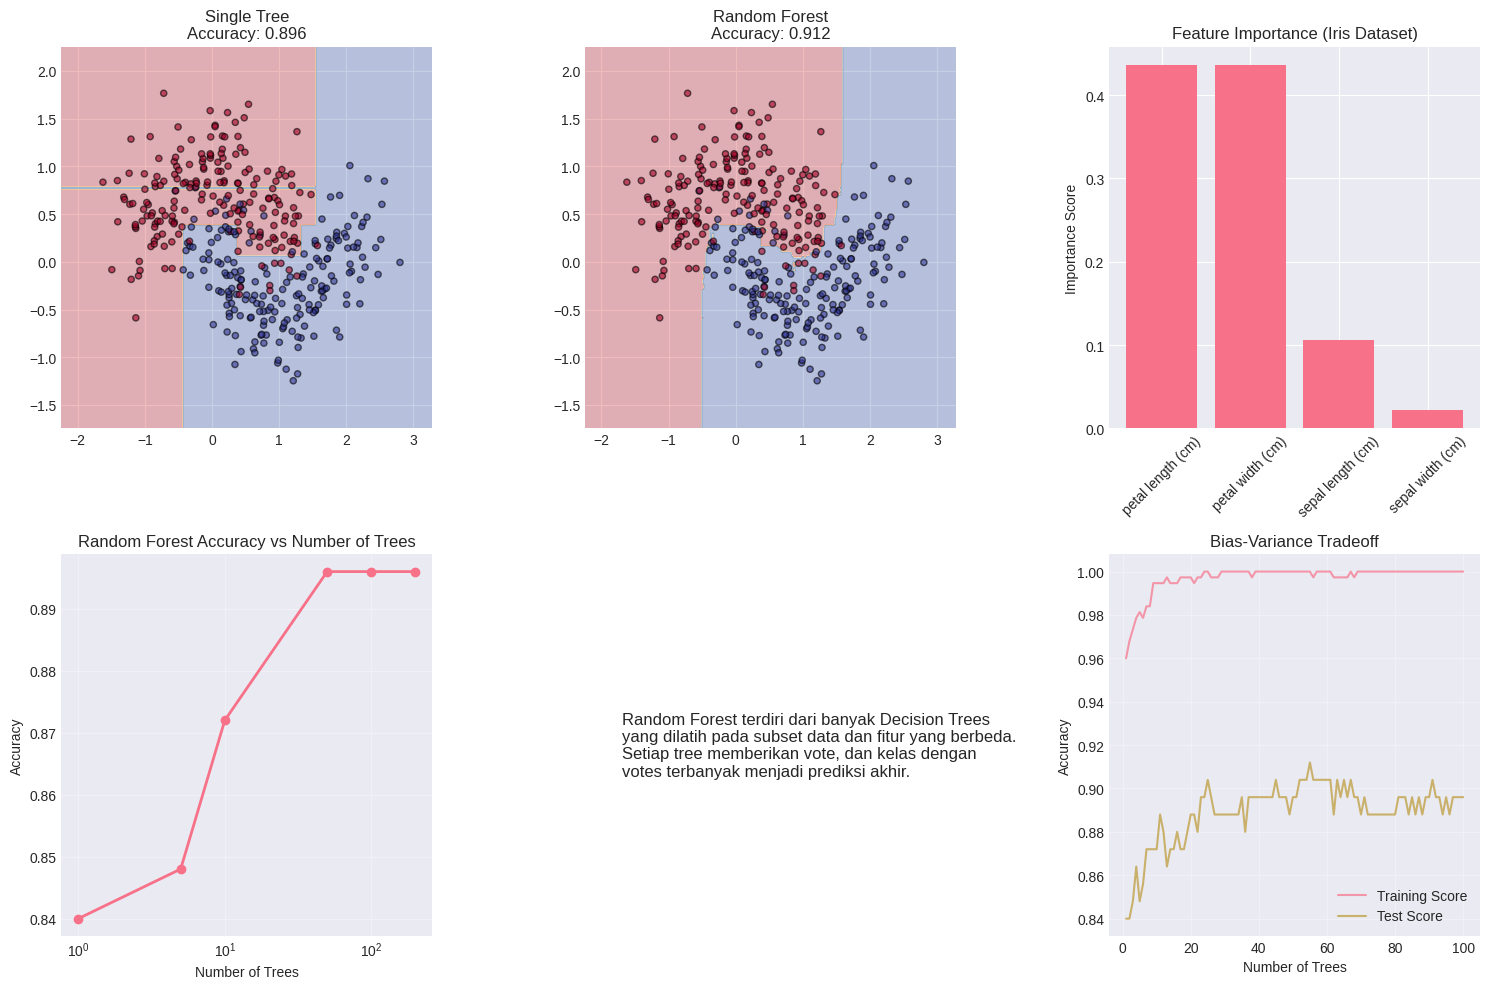

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris

# Visualisasi Random Forest
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# 1. Single Decision Tree vs Random Forest
tree_single = DecisionTreeClassifier(max_depth=5, random_state=42)
tree_single.fit(X_train, y_train)

rf_clf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf_clf.fit(X_train, y_train)

# Plot comparison
for idx, (name, clf) in enumerate([('Single Tree', tree_single), ('Random Forest', rf_clf)]):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axes[0, idx].contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.RdYlBu)
    axes[0, idx].scatter(X_train[:, 0], X_train[:, 1], c=y_train,
                        cmap=plt.cm.RdYlBu, edgecolor='black', s=20, alpha=0.6)
    axes[0, idx].set_title(f'{name}\nAccuracy: {accuracy_score(y_test, clf.predict(X_test)):.3f}')

# 2. Feature Importance (Iris dataset)
iris = load_iris()
X_iris, y_iris = iris.data, iris.target
rf_iris = RandomForestClassifier(n_estimators=100, random_state=42)
rf_iris.fit(X_iris, y_iris)

# Plot feature importance
features = iris.feature_names
importances = rf_iris.feature_importances_
indices = np.argsort(importances)[::-1]

axes[0, 2].bar(range(len(features)), importances[indices])
axes[0, 2].set_xticks(range(len(features)))
axes[0, 2].set_xticklabels([features[i] for i in indices], rotation=45)
axes[0, 2].set_title('Feature Importance (Iris Dataset)')
axes[0, 2].set_ylabel('Importance Score')

# 3. Random Forest dengan berbagai n_estimators
estimator_counts = [1, 5, 10, 50, 100, 200]
accuracies = []

for n in estimator_counts:
    rf_temp = RandomForestClassifier(n_estimators=n, random_state=42)
    rf_temp.fit(X_train, y_train)
    accuracies.append(accuracy_score(y_test, rf_temp.predict(X_test)))

axes[1, 0].plot(estimator_counts, accuracies, marker='o', linewidth=2)
axes[1, 0].set_xlabel('Number of Trees')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].set_title('Random Forest Accuracy vs Number of Trees')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_xscale('log')

# 4. Visualisasi beberapa trees dalam Random Forest
axes[1, 1].axis('off')  # Kosongkan untuk penjelasan
axes[1, 1].text(0.1, 0.5,
                'Random Forest terdiri dari banyak Decision Trees\n'
                'yang dilatih pada subset data dan fitur yang berbeda.\n'
                'Setiap tree memberikan vote, dan kelas dengan\n'
                'votes terbanyak menjadi prediksi akhir.',
                fontsize=12, va='center')

# 5. Convergence plot (bias-variance tradeoff)
train_scores = []
test_scores = []
for n in range(1, 101):
    rf_temp = RandomForestClassifier(n_estimators=n, random_state=42)
    rf_temp.fit(X_train, y_train)
    train_scores.append(accuracy_score(y_train, rf_temp.predict(X_train)))
    test_scores.append(accuracy_score(y_test, rf_temp.predict(X_test)))

axes[1, 2].plot(range(1, 101), train_scores, label='Training Score', alpha=0.7)
axes[1, 2].plot(range(1, 101), test_scores, label='Test Score', alpha=0.7)
axes[1, 2].set_xlabel('Number of Trees')
axes[1, 2].set_ylabel('Accuracy')
axes[1, 2].set_title('Bias-Variance Tradeoff')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# **5. Extra-Trees vs Random Forest**
---

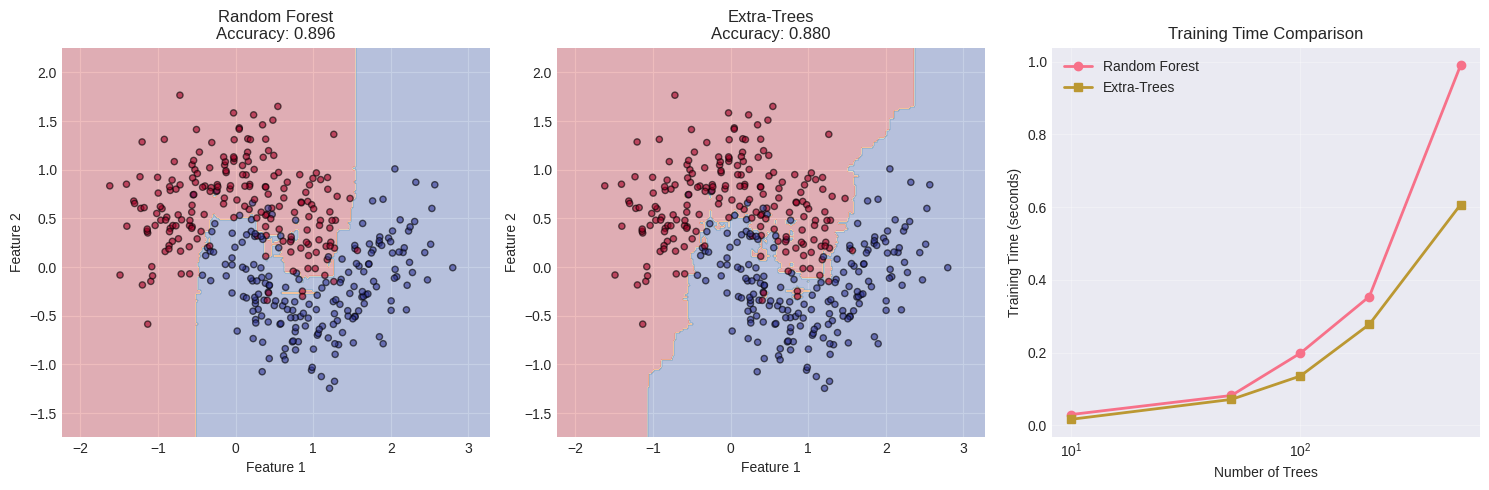

Perbedaan Extra-Trees vs Random Forest:
1. Extra-Trees menggunakan random thresholds (lebih random)
2. Extra-Trees biasanya lebih cepat untuk training
3. Extra-Trees memiliki bias lebih tinggi, variance lebih rendah
4. Performa tergantung dataset - perlu cross-validation


In [5]:
from sklearn.ensemble import ExtraTreesClassifier

# Visualisasi perbandingan
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Train models
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
extra_clf = ExtraTreesClassifier(n_estimators=100, random_state=42)

rf_clf.fit(X_train, y_train)
extra_clf.fit(X_train, y_train)

# Plot decision boundaries
models = [('Random Forest', rf_clf), ('Extra-Trees', extra_clf)]

for idx, (name, clf) in enumerate(models):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axes[idx].contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.RdYlBu)
    axes[idx].scatter(X_train[:, 0], X_train[:, 1], c=y_train,
                     cmap=plt.cm.RdYlBu, edgecolor='black', s=20, alpha=0.6)
    axes[idx].set_title(f'{name}\nAccuracy: {accuracy_score(y_test, clf.predict(X_test)):.3f}')
    axes[idx].set_xlabel('Feature 1')
    axes[idx].set_ylabel('Feature 2')

# Plot waktu training
import time

rf_times = []
extra_times = []
n_trees_range = [10, 50, 100, 200, 500]

for n in n_trees_range:
    # Random Forest
    start = time.time()
    rf_temp = RandomForestClassifier(n_estimators=n, random_state=42, n_jobs=-1)
    rf_temp.fit(X_train, y_train)
    rf_times.append(time.time() - start)

    # Extra-Trees
    start = time.time()
    extra_temp = ExtraTreesClassifier(n_estimators=n, random_state=42, n_jobs=-1)
    extra_temp.fit(X_train, y_train)
    extra_times.append(time.time() - start)

axes[2].plot(n_trees_range, rf_times, marker='o', label='Random Forest', linewidth=2)
axes[2].plot(n_trees_range, extra_times, marker='s', label='Extra-Trees', linewidth=2)
axes[2].set_xlabel('Number of Trees')
axes[2].set_ylabel('Training Time (seconds)')
axes[2].set_title('Training Time Comparison')
axes[2].legend()
axes[2].grid(True, alpha=0.3)
axes[2].set_xscale('log')

plt.tight_layout()
plt.show()

print("Perbedaan Extra-Trees vs Random Forest:")
print("1. Extra-Trees menggunakan random thresholds (lebih random)")
print("2. Extra-Trees biasanya lebih cepat untuk training")
print("3. Extra-Trees memiliki bias lebih tinggi, variance lebih rendah")
print("4. Performa tergantung dataset - perlu cross-validation")

# **6. Boosting Methods**
---
1. AdaBoost

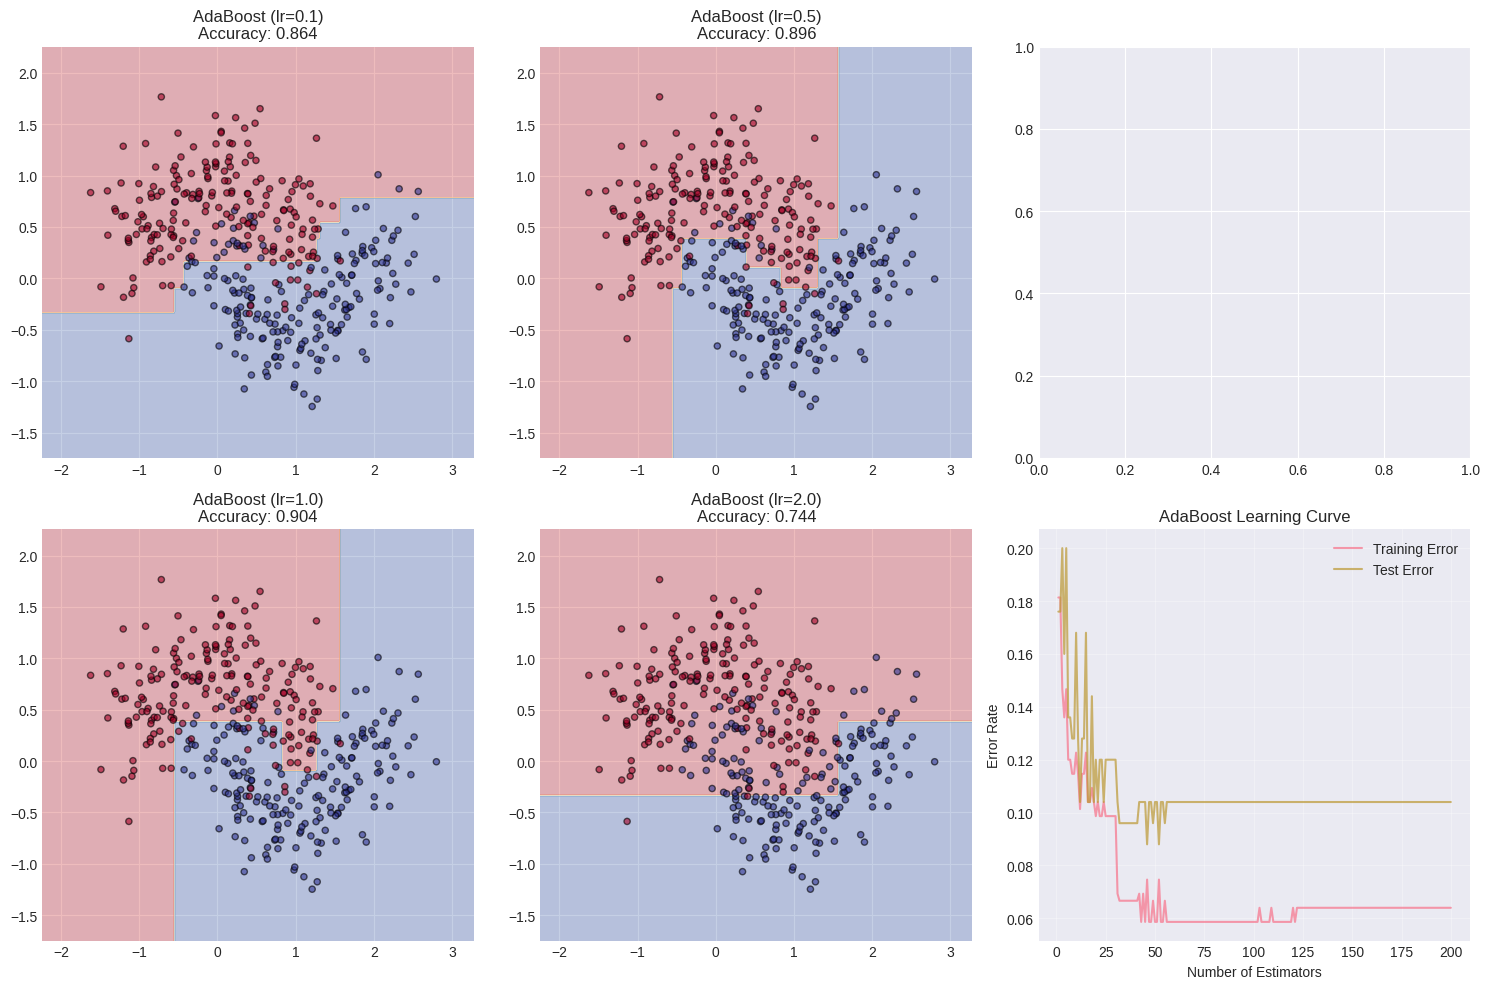

In [6]:
from sklearn.ensemble import AdaBoostClassifier

# Visualisasi AdaBoost
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# AdaBoost dengan berbagai learning rates
learning_rates = [0.1, 0.5, 1.0, 2.0]
colors = plt.cm.viridis(np.linspace(0, 1, len(learning_rates)))

for idx, lr in enumerate(learning_rates):
    ada_clf = AdaBoostClassifier(
        DecisionTreeClassifier(max_depth=1),
        n_estimators=50,
        learning_rate=lr,
        random_state=42
    )
    ada_clf.fit(X_train, y_train)

    Z = ada_clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    row = idx // 2
    col = idx % 2

    axes[row, col].contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.RdYlBu)
    axes[row, col].scatter(X_train[:, 0], X_train[:, 1], c=y_train,
                          cmap=plt.cm.RdYlBu, edgecolor='black', s=20, alpha=0.6)
    axes[row, col].set_title(f'AdaBoost (lr={lr})\nAccuracy: {accuracy_score(y_test, ada_clf.predict(X_test)):.3f}')

# Plot error reduction selama training
ada_clf_full = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),
    n_estimators=200,
    learning_rate=0.5,
    random_state=42
)

train_errors = []
test_errors = []

for n in range(1, 201):
    ada_clf_full.set_params(n_estimators=n)
    ada_clf_full.fit(X_train, y_train)
    train_errors.append(1 - accuracy_score(y_train, ada_clf_full.predict(X_train)))
    test_errors.append(1 - accuracy_score(y_test, ada_clf_full.predict(X_test)))

axes[1, 2].plot(range(1, 201), train_errors, label='Training Error', alpha=0.7)
axes[1, 2].plot(range(1, 201), test_errors, label='Test Error', alpha=0.7)
axes[1, 2].set_xlabel('Number of Estimators')
axes[1, 2].set_ylabel('Error Rate')
axes[1, 2].set_title('AdaBoost Learning Curve')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

2. Gradient Boosting


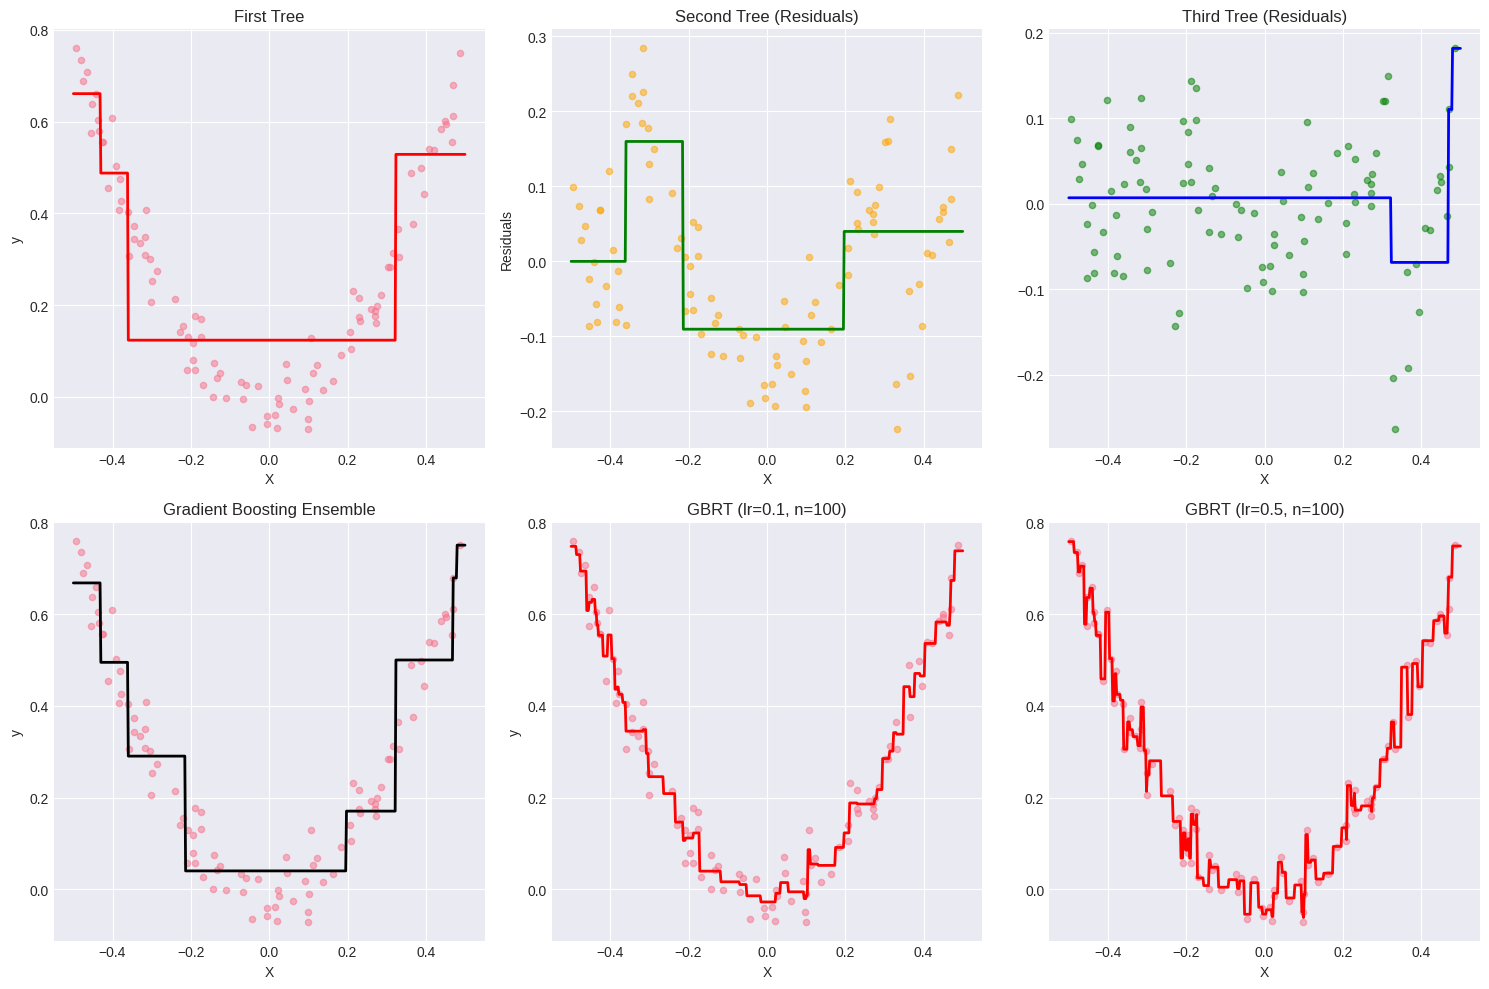

NameError: name 'mean_squared_error' is not defined

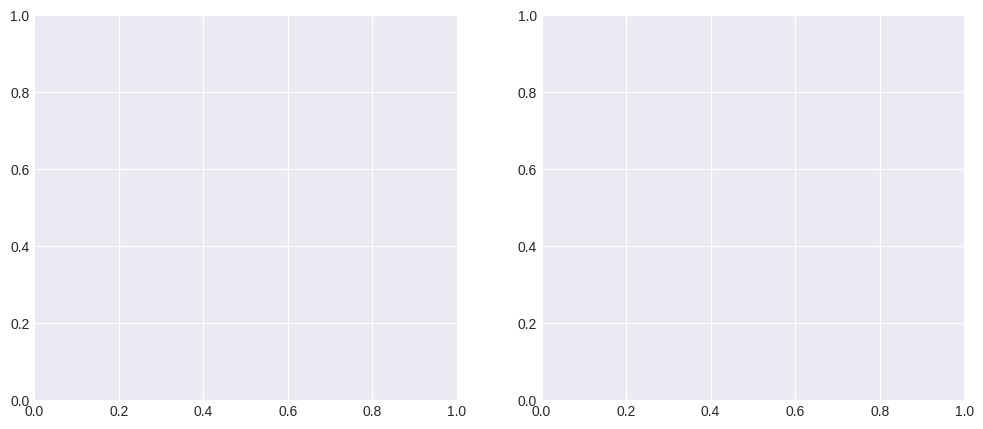

In [8]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor

# Generate data untuk regression
np.random.seed(42)
X_gb = np.random.rand(100, 1) - 0.5
y_gb = 3 * X_gb[:, 0]**2 + 0.05 * np.random.randn(100)

# Visualisasi Gradient Boosting
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Manual Gradient Boosting (3 trees)
tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X_gb, y_gb)

y2 = y_gb - tree_reg1.predict(X_gb)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X_gb, y2)

y3 = y2 - tree_reg2.predict(X_gb)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X_gb, y3)

# Plot individual trees dan ensemble
X_new = np.linspace(-0.5, 0.5, 500).reshape(-1, 1)

axes[0, 0].scatter(X_gb, y_gb, s=20, alpha=0.5)
axes[0, 0].plot(X_new, tree_reg1.predict(X_new), "r-", linewidth=2, label="Tree 1")
axes[0, 0].set_title("First Tree")
axes[0, 0].set_xlabel("X")
axes[0, 0].set_ylabel("y")

axes[0, 1].scatter(X_gb, y2, s=20, alpha=0.5, color='orange')
axes[0, 1].plot(X_new, tree_reg2.predict(X_new), "g-", linewidth=2, label="Tree 2")
axes[0, 1].set_title("Second Tree (Residuals)")
axes[0, 1].set_xlabel("X")
axes[0, 1].set_ylabel("Residuals")

axes[0, 2].scatter(X_gb, y3, s=20, alpha=0.5, color='green')
axes[0, 2].plot(X_new, tree_reg3.predict(X_new), "b-", linewidth=2, label="Tree 3")
axes[0, 2].set_title("Third Tree (Residuals)")
axes[0, 2].set_xlabel("X")

# Plot ensemble predictions
def gradient_boosting_predict(X):
    return sum(tree.predict(X) for tree in (tree_reg1, tree_reg2, tree_reg3))

y_pred_gb = gradient_boosting_predict(X_new)

axes[1, 0].scatter(X_gb, y_gb, s=20, alpha=0.5)
axes[1, 0].plot(X_new, y_pred_gb, "k-", linewidth=2, label="Ensemble")
axes[1, 0].set_title("Gradient Boosting Ensemble")
axes[1, 0].set_xlabel("X")
axes[1, 0].set_ylabel("y")

# Plot learning rate effect
# Adjusted the list of learning rates to fit the available subplots
for idx, lr in enumerate([0.1, 0.5]):
    gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=100,
                                     learning_rate=lr, random_state=42)
    gbrt.fit(X_gb, y_gb)

    row = 1
    col = idx + 1
    axes[row, col].scatter(X_gb, y_gb, s=20, alpha=0.5)
    axes[row, col].plot(X_new, gbrt.predict(X_new), "r-", linewidth=2)
    axes[row, col].set_title(f"GBRT (lr={lr}, n=100)")
    axes[row, col].set_xlabel("X")
    if col == 1:
        axes[row, col].set_ylabel("y")

plt.tight_layout()
plt.show()

# Early stopping visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

X_train_gb, X_val_gb, y_train_gb, y_val_gb = train_test_split(
    X_gb, y_gb, test_size=0.2, random_state=42
)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train_gb, y_train_gb)

errors = [mean_squared_error(y_val_gb, y_pred)
          for y_pred in gbrt.staged_predict(X_val_gb)]
best_n_estimators = np.argmin(errors) + 1

# Plot validation error
axes[0].plot(range(1, 121), errors, 'b-', linewidth=2)
axes[0].axvline(x=best_n_estimators, color='r', linestyle='--', label=f'Best: {best_n_estimators} trees')
axes[0].set_xlabel('Number of Trees')
axes[0].set_ylabel('Validation MSE')
axes[0].set_title('Early Stopping in Gradient Boosting')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot best model
gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=best_n_estimators,
                                      random_state=42)
gbrt_best.fit(X_train_gb, y_train_gb)

axes[1].scatter(X_gb, y_gb, s=20, alpha=0.5)
axes[1].plot(X_new, gbrt_best.predict(X_new), "r-", linewidth=2,
            label=f'Best Model ({best_n_estimators} trees)')
axes[1].set_xlabel('X')
axes[1].set_ylabel('y')
axes[1].set_title(f'Optimal Model (MSE: {min(errors):.4f})')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# **7. Stacking Ensemble**
---

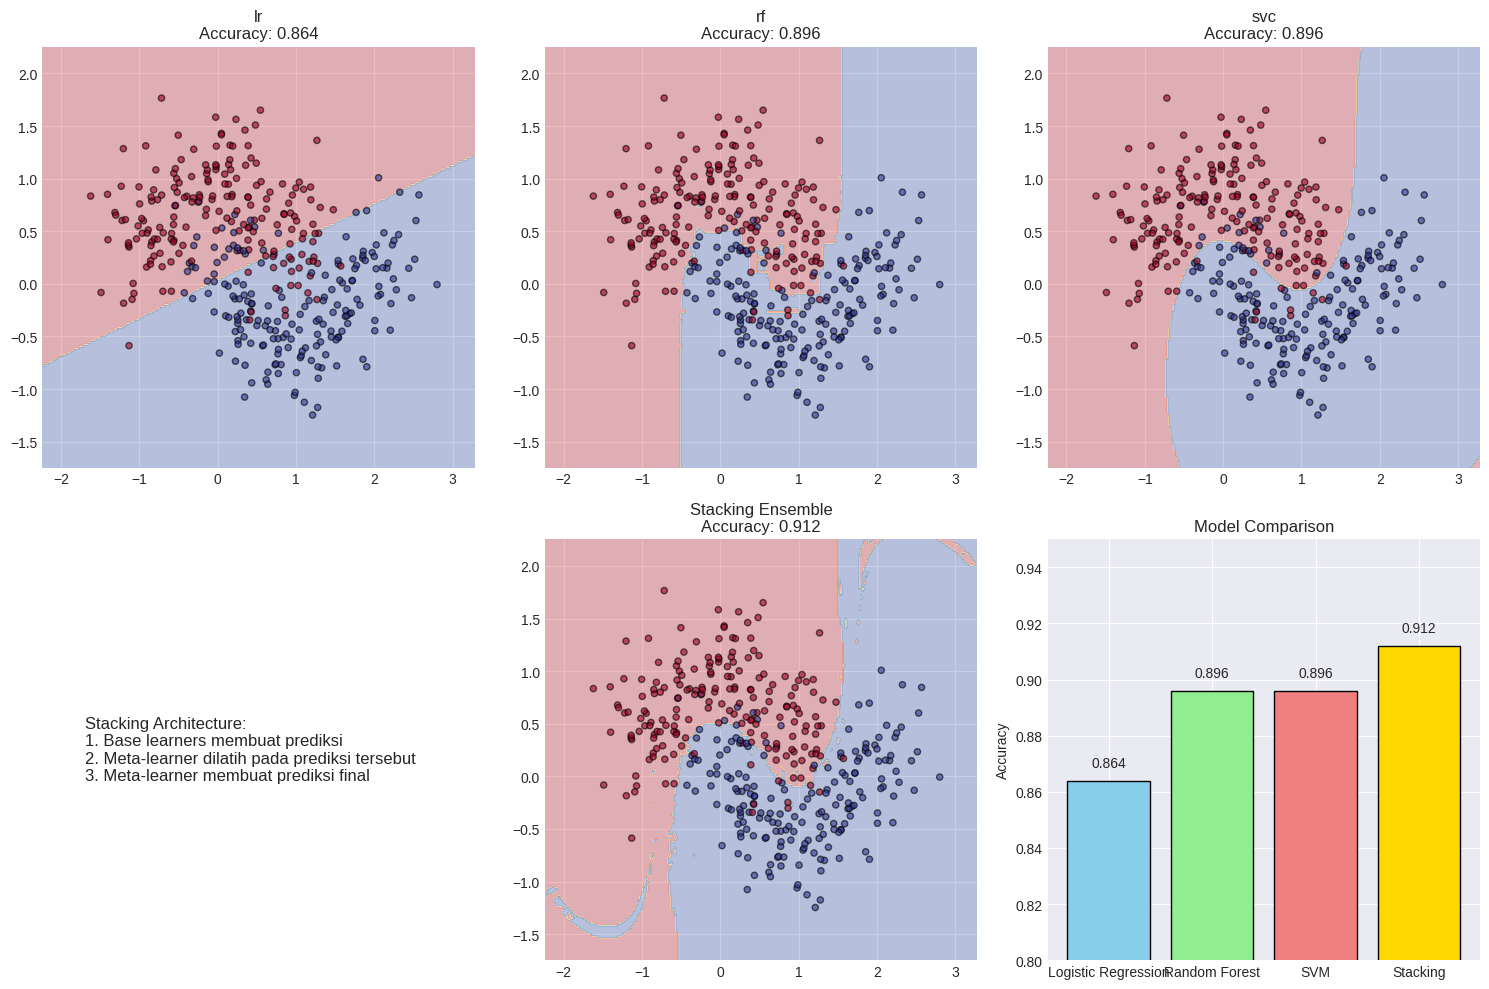

In [9]:
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import cross_val_score
from mlxtend.plotting import plot_decision_regions

# Create stacking ensemble
base_learners = [
    ('lr', LogisticRegression(random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('svc', SVC(probability=True, random_state=42))
]

stacking_clf = StackingClassifier(
    estimators=base_learners,
    final_estimator=RandomForestClassifier(n_estimators=100, random_state=42),
    cv=5
)

# Visualisasi stacking
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Train dan plot base learners
for idx, (name, clf) in enumerate(base_learners):
    clf.fit(X_train, y_train)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    row = idx // 3
    col = idx % 3

    axes[row, col].contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.RdYlBu)
    axes[row, col].scatter(X_train[:, 0], X_train[:, 1], c=y_train,
                          cmap=plt.cm.RdYlBu, edgecolor='black', s=20, alpha=0.6)
    axes[row, col].set_title(f'{name}\nAccuracy: {accuracy_score(y_test, clf.predict(X_test)):.3f}')

# Train stacking classifier
stacking_clf.fit(X_train, y_train)

# Plot stacking classifier
Z = stacking_clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

axes[1, 1].contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.RdYlBu)
axes[1, 1].scatter(X_train[:, 0], X_train[:, 1], c=y_train,
                  cmap=plt.cm.RdYlBu, edgecolor='black', s=20, alpha=0.6)
axes[1, 1].set_title(f'Stacking Ensemble\nAccuracy: {accuracy_score(y_test, stacking_clf.predict(X_test)):.3f}')

# Plot comparison bar chart
models = ['Logistic Regression', 'Random Forest', 'SVM', 'Stacking']
accuracies = [
    accuracy_score(y_test, base_learners[0][1].predict(X_test)),
    accuracy_score(y_test, base_learners[1][1].predict(X_test)),
    accuracy_score(y_test, base_learners[2][1].predict(X_test)),
    accuracy_score(y_test, stacking_clf.predict(X_test))
]

colors = ['skyblue', 'lightgreen', 'lightcoral', 'gold']
axes[1, 2].bar(models, accuracies, color=colors, edgecolor='black')
axes[1, 2].set_ylabel('Accuracy')
axes[1, 2].set_title('Model Comparison')
axes[1, 2].set_ylim(0.8, 0.95)
for i, v in enumerate(accuracies):
    axes[1, 2].text(i, v + 0.005, f'{v:.3f}', ha='center')

axes[1, 0].axis('off')  # Kosongkan
axes[1, 0].text(0.1, 0.5,
                'Stacking Architecture:\n'
                '1. Base learners membuat prediksi\n'
                '2. Meta-learner dilatih pada prediksi tersebut\n'
                '3. Meta-learner membuat prediksi final',
                fontsize=12, va='center')

plt.tight_layout()
plt.show()

# **8. Perbandingan Komprehensif Semua Metode**
---

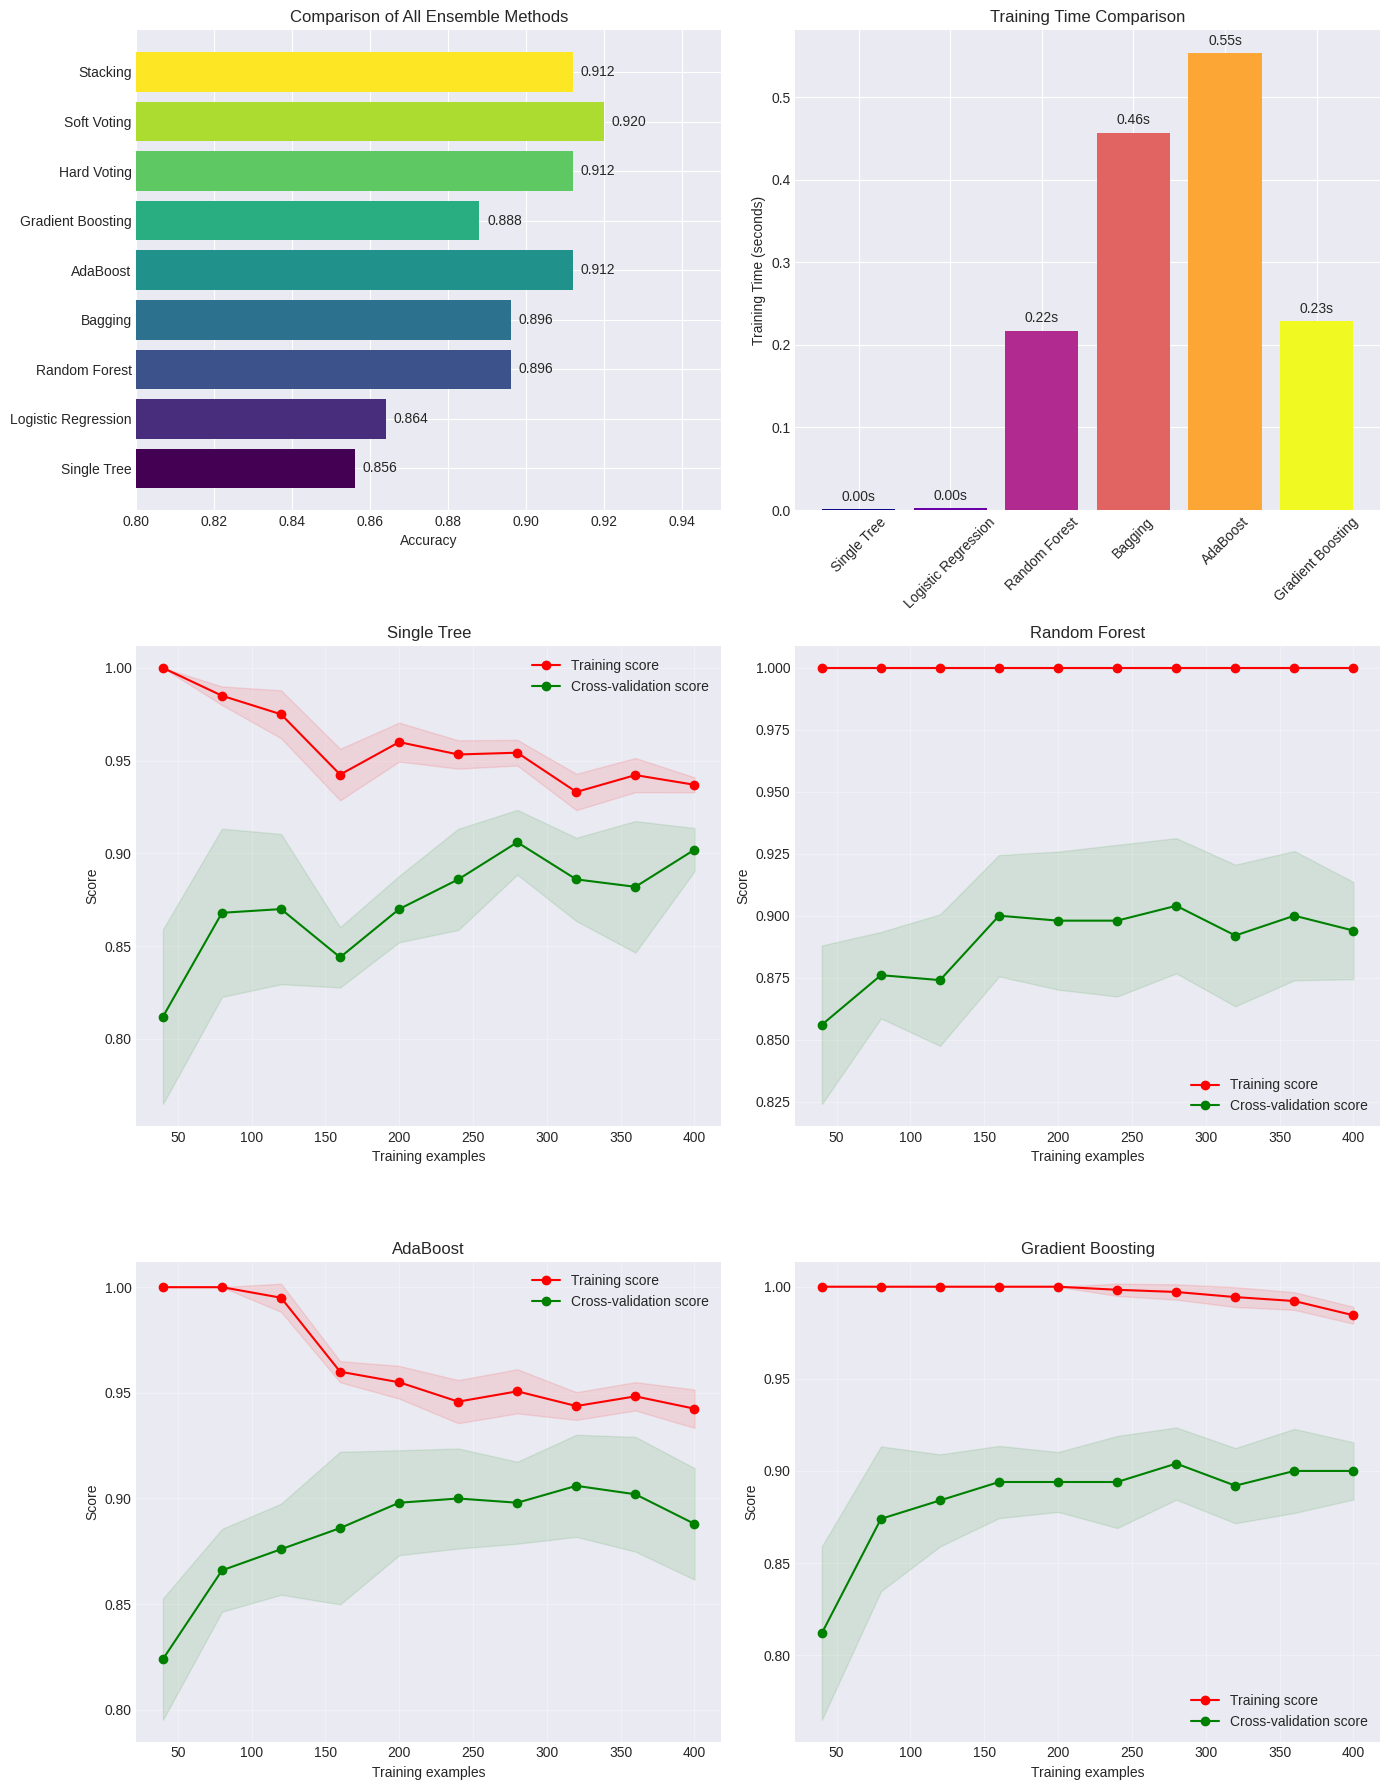

KESIMPULAN CHAPTER 7: ENSEMBLE LEARNING

1. VOTING CLASSIFIERS:
   - Hard voting: pilih kelas dengan suara terbanyak
   - Soft voting: rata-rata probabilitas, biasanya lebih baik
   - Memerlukan diversity antar classifier

2. BAGGING & PASTING:
   - Bagging: sampling dengan replacement (bootstrap)
   - Pasting: sampling tanpa replacement
   - Mengurangi variance, bisa parallelized
   - OOB evaluation: evaluasi tanpa validation set terpisah

3. RANDOM FORESTS:
   - Ensemble Decision Trees dengan randomness ekstra
   - Feature importance: identifikasi fitur penting
   - Robust terhadap overfitting

4. EXTRA-TREES:
   - Lebih random daripada Random Forest
   - Lebih cepat, bias lebih tinggi, variance lebih rendah

5. BOOSTING:
   - AdaBoost: memberi weight pada instance salah
   - Gradient Boosting: fitting pada residual errors
   - Sequential training, tidak bisa full parallel
   - XGBoost: optimized implementation yang sangat populer

6. STACKING:
   - Meta-learner menggabungkan prediks

In [10]:
# Ringkasan semua metode ensemble
fig, axes = plt.subplots(3, 2, figsize=(14, 18)) # Changed from (2, 2) to (3, 2) and increased figsize

# 1. Akurasi semua metode
from sklearn.ensemble import GradientBoostingClassifier
all_models = {
    'Single Tree': DecisionTreeClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Bagging': BaggingClassifier(DecisionTreeClassifier(), n_estimators=100, random_state=42),
    'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'Hard Voting': voting_clf_hard,
    'Soft Voting': voting_clf_soft,
    'Stacking': stacking_clf
}

# Hitung akurasi
accuracies = []
model_names = []
for name, model in all_models.items():
    if name not in ['Hard Voting', 'Soft Voting', 'Stacking']:
        model.fit(X_train, y_train)
    acc = accuracy_score(y_test, model.predict(X_test))
    accuracies.append(acc)
    model_names.append(name)

# Plot akurasi
bars = axes[0, 0].barh(model_names, accuracies, color=plt.cm.viridis(np.linspace(0, 1, len(model_names))))
axes[0, 0].set_xlabel('Accuracy')
axes[0, 0].set_title('Comparison of All Ensemble Methods')
axes[0, 0].set_xlim(0.8, 0.95)
for i, (bar, acc) in enumerate(zip(bars, accuracies)):
    axes[0, 0].text(acc + 0.002, bar.get_y() + bar.get_height()/2,
                   f'{acc:.3f}', va='center')

# 2. Training time comparison
import time
training_times = []
for name, model in list(all_models.items())[:6]:  # Ambil 6 pertama untuk clarity
    start = time.time()
    model.fit(X_train, y_train)
    training_times.append(time.time() - start)

axes[0, 1].bar(list(all_models.keys())[:6], training_times,
               color=plt.cm.plasma(np.linspace(0, 1, 6)))
axes[0, 1].set_ylabel('Training Time (seconds)')
axes[0, 1].set_title('Training Time Comparison')
axes[0, 1].tick_params(axis='x', rotation=45)
for i, v in enumerate(training_times):
    axes[0, 1].text(i, v + 0.01, f'{v:.2f}s', ha='center')

# 3. Bias-Variance Tradeoff visualization
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, ax):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10)
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    ax.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    ax.set_xlabel("Training examples")
    ax.set_ylabel("Score")
    ax.set_title(title)
    ax.legend(loc="best")
    ax.grid(True, alpha=0.3)

# Plot untuk 4 model berbeda
models_lc = [
    (DecisionTreeClassifier(max_depth=5, random_state=42), "Single Tree"),
    (RandomForestClassifier(n_estimators=100, random_state=42), "Random Forest"),
    (AdaBoostClassifier(n_estimators=100, random_state=42), "AdaBoost"),
    (GradientBoostingClassifier(n_estimators=100, random_state=42), "Gradient Boosting")
]

for idx, (model, title) in enumerate(models_lc):
    row = 1 + idx // 2 # Now 1 + (0 or 1) // 2 = 1 or 1 + (2 or 3) // 2 = 2
    col = idx % 2
    plot_learning_curve(model, title, axes[row, col])

plt.tight_layout()
plt.show()

# Ringkasan akhir
print("="*60)
print("KESIMPULAN CHAPTER 7: ENSEMBLE LEARNING")
print("="*60)
print("\n1. VOTING CLASSIFIERS:")
print("   - Hard voting: pilih kelas dengan suara terbanyak")
print("   - Soft voting: rata-rata probabilitas, biasanya lebih baik")
print("   - Memerlukan diversity antar classifier")

print("\n2. BAGGING & PASTING:")
print("   - Bagging: sampling dengan replacement (bootstrap)")
print("   - Pasting: sampling tanpa replacement")
print("   - Mengurangi variance, bisa parallelized")
print("   - OOB evaluation: evaluasi tanpa validation set terpisah")

print("\n3. RANDOM FORESTS:")
print("   - Ensemble Decision Trees dengan randomness ekstra")
print("   - Feature importance: identifikasi fitur penting")
print("   - Robust terhadap overfitting")

print("\n4. EXTRA-TREES:\n   - Lebih random daripada Random Forest\n   - Lebih cepat, bias lebih tinggi, variance lebih rendah")

print("\n5. BOOSTING:")
print("   - AdaBoost: memberi weight pada instance salah")
print("   - Gradient Boosting: fitting pada residual errors")
print("   - Sequential training, tidak bisa full parallel")
print("   - XGBoost: optimized implementation yang sangat populer")

print("\n6. STACKING:")
print("   - Meta-learner menggabungkan prediksi base learners")
print("   - Lebih powerful tetapi lebih kompleks")
print("   - Memerlukan careful validation untuk menghindari overfitting")

print("\n" + "="*60)
print("REKOMENDASI UMUM:")
print("1. Mulai dengan Random Forest - robust dan mudah di-tune")
print("2. Untuk akurasi maksimal: coba Gradient Boosting/XGBoost")
print("3. Untuk interpretability: gunakan feature importance dari Random Forest")
print("4. Untuk large datasets: gunakan bagging (bisa parallel)")
print("5. Dalam kompetisi: stacking sering menjadi pemenang")
print("="*60)
